A notebook to visualize the av2 dataset along with its annotations

In [1]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import  AV2SensorDataLoader
from pathlib import Path

home = os.path.expanduser("~")

dataset_path = os.path.join(home,"buni","dataset", "av2", "train")

os.listdir(dataset_path)

dataset = AV2SensorDataLoader(Path(dataset_path), Path(dataset_path))
print(dataset.get_log_ids()[0])
log_id = dataset.get_log_ids()[0]
print(dataset.get_ordered_log_lidar_timestamps(log_id)[0])
timestamp = dataset.get_ordered_log_lidar_timestamps(log_id)[0]


ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd
315968335160099000


In [3]:
labels = dataset.get_labels_at_lidar_timestamp(log_id, timestamp)
corners = labels.vertices_m

In [4]:
import numpy as np
row = corners[0,:]

row_rounded = np.round(row, decimals=3)
row_rounded_2d = np.round(row[:,:2], decimals=3)

vertex_0 = corners[0,0,:2]
vertex_1 = corners[0,1,:2]
vertex_4 = corners[0,4,:2]
vertex_5 = corners[0,5,:2]
vertex_0.shape


(2,)

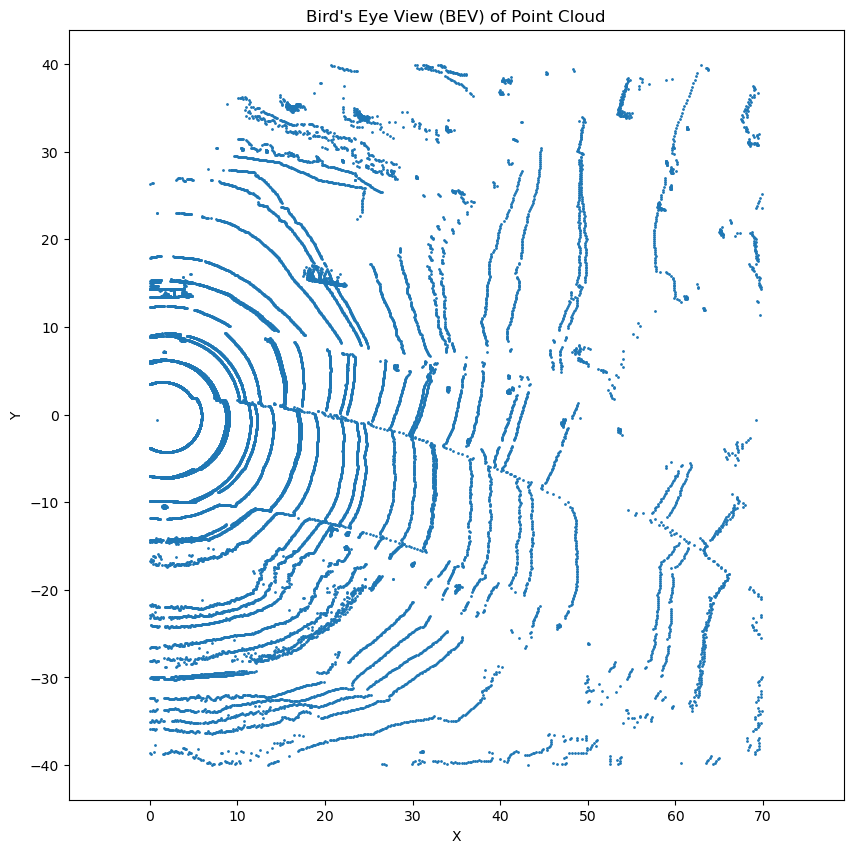

In [5]:
from av2.structures.sweep import Sweep
import matplotlib.pyplot as plt
import numpy as np
from prototype_utils import filter_roi

sweep = Sweep.from_feather(dataset.get_lidar_fpath_at_lidar_timestamp(log_id, timestamp))
points = sweep.xyz
filtered_points = filter_roi(points)
def viz_points2d(points: np.ndarray):
    # Assuming points is an nx3 numpy array
    x = points[:, 0]
    y = points[:, 1]
    plt.figure(figsize=(10, 10))
    plt.scatter(x, y, s=1)  # s is the marker size
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Bird\'s Eye View (BEV) of Point Cloud')
    plt.axis('equal')
    plt.show()
    
viz_points2d(filtered_points)

In [6]:
import open3d as o3d

def viz_pd(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # add coordinat axes to the point cloud
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])
    o3d.visualization.draw_geometries([pcd, mesh_frame])

viz_pd(points)

In [7]:
import open3d as o3d
import numpy as np

def visualize_pointcloud_with_cuboids(points, cuboids):
    """
    Visualize a point cloud with cuboids.
    
    Args:
        points (numpy.ndarray): Nx3 array representing the point cloud.
        cuboids (list of numpy.ndarray): Each element is an 8x3 array representing 
                                         the corners of a cuboid.
    """
    # Create Open3D point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # Create coordinate frame for reference
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])
    
    # Generate Open3D LineSets for cuboids
    cuboid_geometries = []
    for cuboid in cuboids:
        # Line connections for cuboid wireframe
        lines = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
            [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
            [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
        ]
        
        # Create LineSet for this cuboid
        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(cuboid)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector([[1, 0, 0] for _ in lines])  # Red color
        
        cuboid_geometries.append(line_set)
    
    # Visualize point cloud and cuboids
    o3d.visualization.draw_geometries([pcd, mesh_frame] + cuboid_geometries)

# Example usage
# `points` is the Nx3 point cloud array
# `cuboids` is a list of 8x3 arrays representing cuboid corners
visualize_pointcloud_with_cuboids(points, corners)


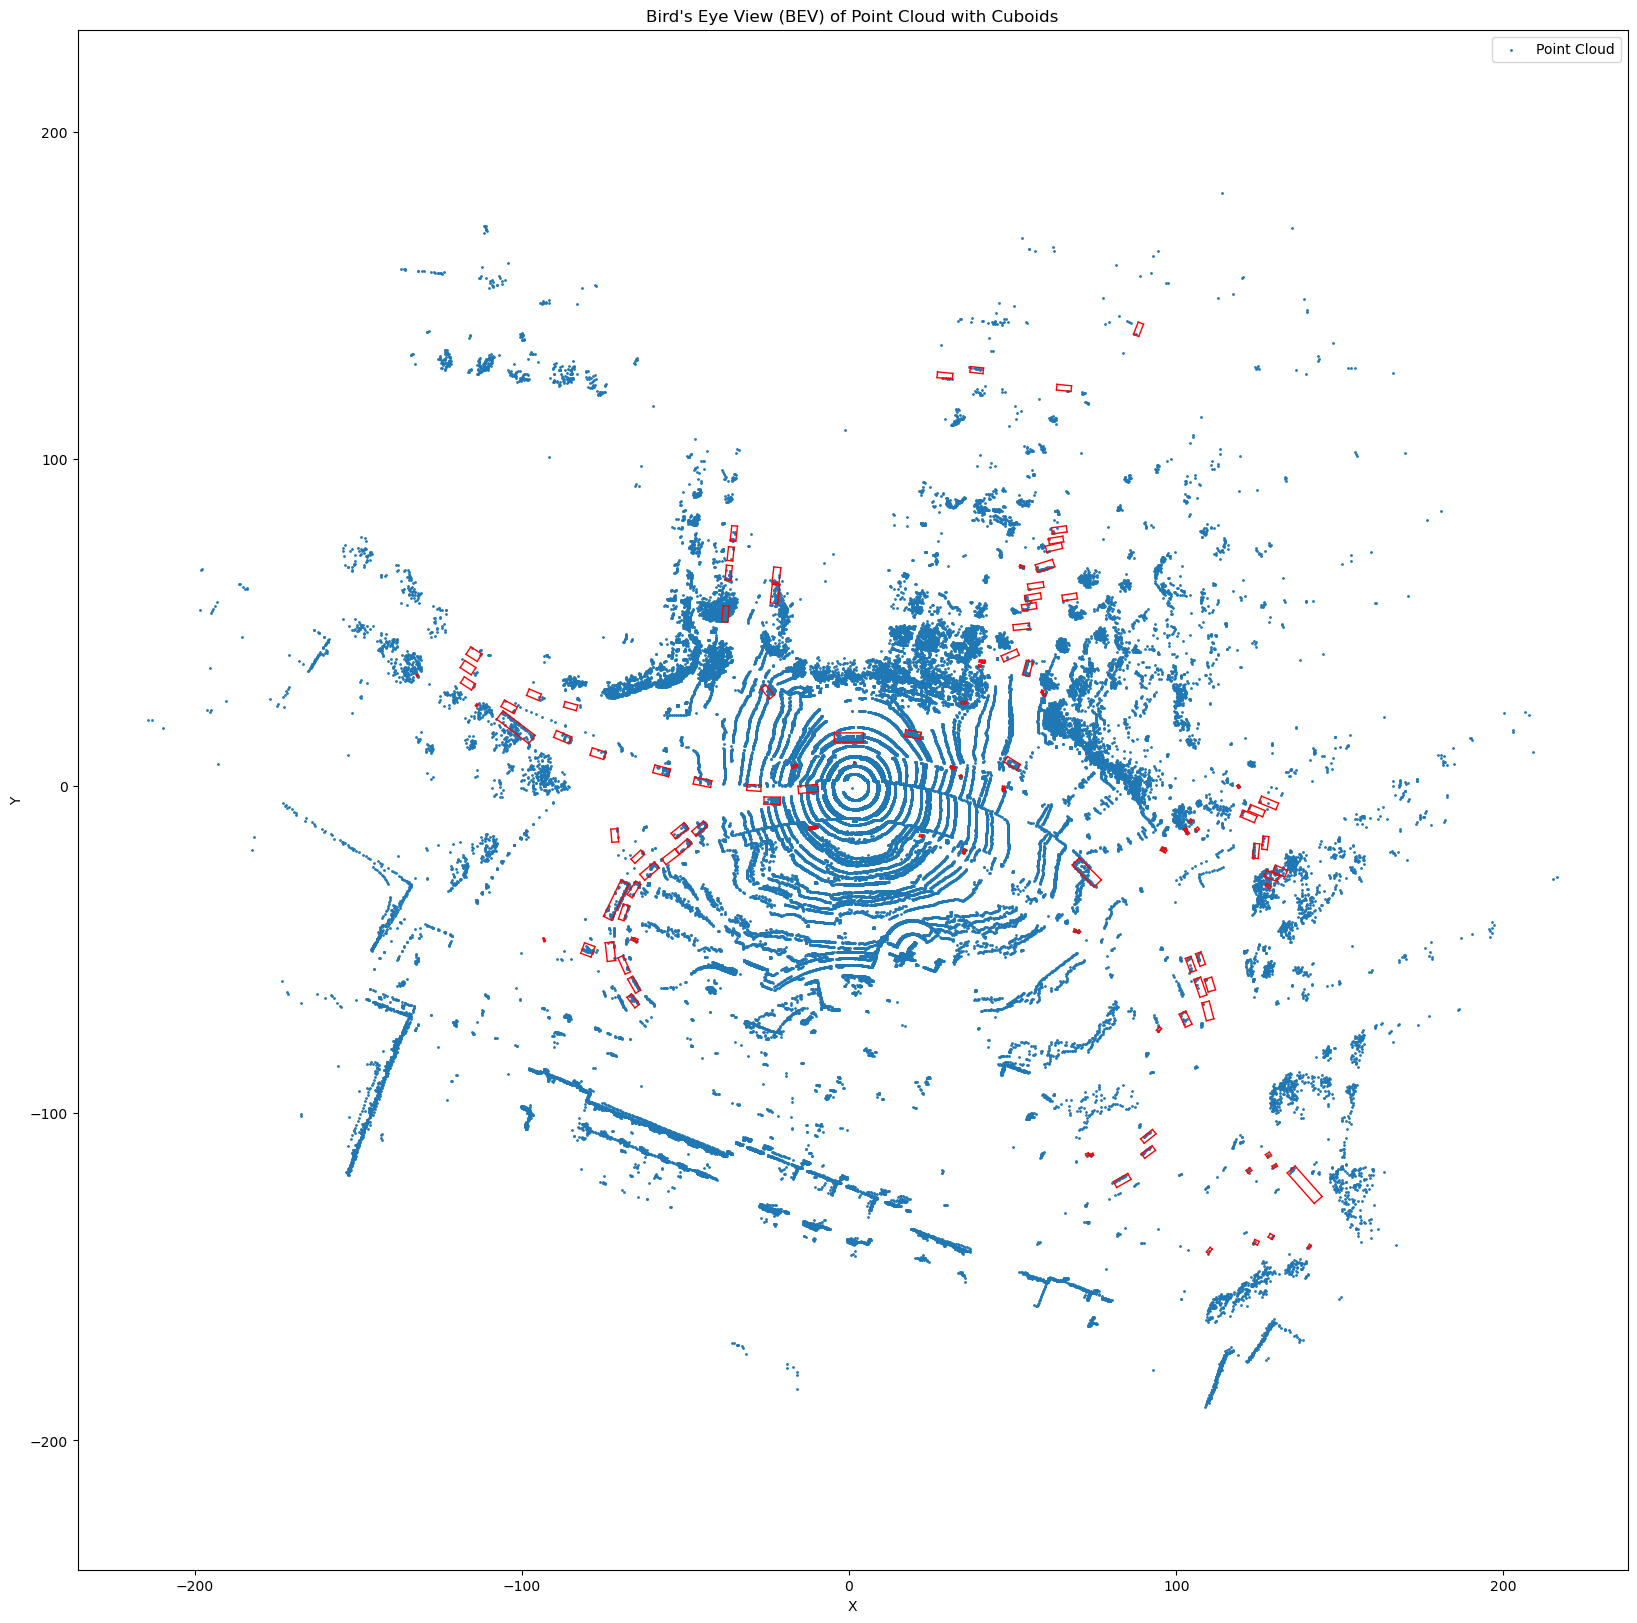

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bev_with_cuboids(points: np.ndarray, cuboids: np.ndarray, fig_size = (10,10), bottom_face_flag= True):
    """
    Visualize a 2D BEV (Bird's Eye View) of the point cloud with cuboid annotations.

    Args:
        points (numpy.ndarray): Nx3 array representing the point cloud.
        cuboids (numpy.ndarray): Array of shape (N, 8, 3), where N is the number of cuboids,
                                 8 represents the 8 corners, and 3 represents (X, Y, Z) coordinates.
    
            5------4
            |\\    |\\
            | \\   | \\
            6--\\--7  \\
            \\  \\  \\ \\
        l    \\  1-------0    h
         e    \\ ||   \\ ||   e
          n    \\||    \\||   i
           g    \\2------3    g
            t      width.     h
             h.               t
    """
    # Extract the X and Y coordinates from the point cloud
    x = points[:, 0]
    y = points[:, 1]

    # Plot the BEV of the point cloud
    plt.figure(figsize=fig_size)
    plt.scatter(x, y, s=1, label="Point Cloud")  # s=1 for small point size
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Bird's Eye View (BEV) of Point Cloud with Cuboids")
    plt.axis('equal')

    # Process and visualize each cuboid
    for cuboid in cuboids:
        face_index = []
        if bottom_face_flag:
            face_index = [0, 1, 5, 4]
        else: 
            face_index = [3, 2, 6, 7]
        projected_corners = cuboid[face_index, :2]  # Take only the X-Y coordinates

        # Define connections for the cuboid's bottom face (BEV)
        connections = [
            [0, 1], [1, 2], [2, 3], [3, 0]  # Connections between corners of the bottom face
        ]

        # Draw lines for the cuboid in the BEV
        for start, end in connections:
            plt.plot(
                [projected_corners[start, 0], projected_corners[end, 0]],
                [projected_corners[start, 1], projected_corners[end, 1]],
                color='red', linewidth=1
            )
    
    plt.legend()
    plt.show()

# Example Usage:
# Assuming `points` is an Nx3 numpy array representing the point cloud
# Assuming `cuboids` is an (N, 8, 3) numpy array of cuboid corner coordinates
visualize_bev_with_cuboids(points, corners, fig_size=(20,20), bottom_face_flag=False)


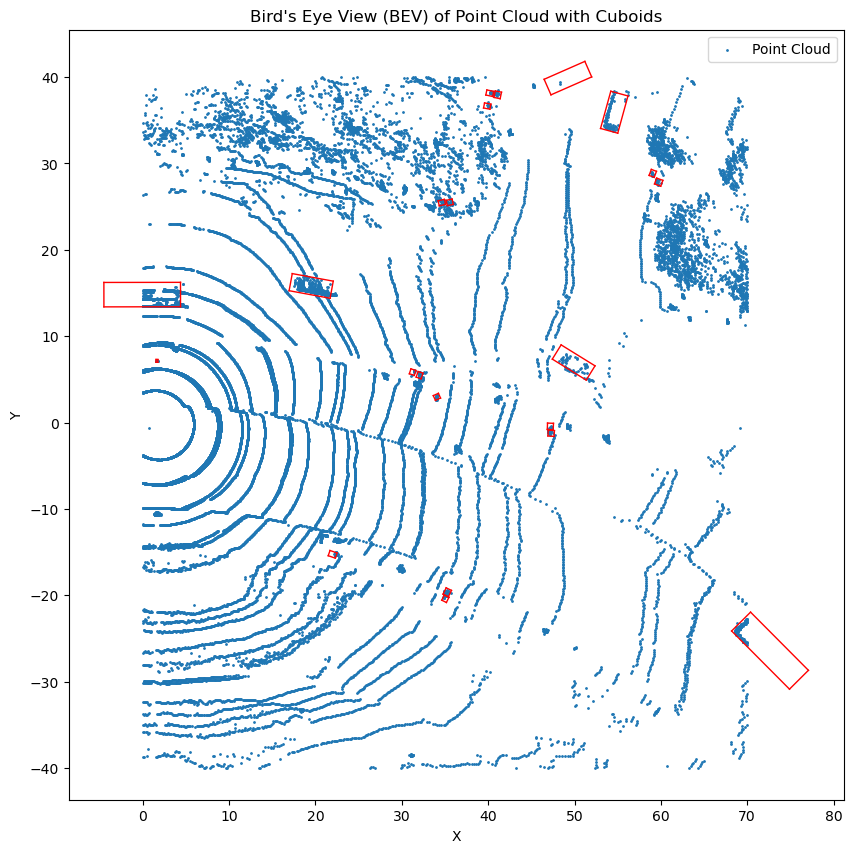

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bev_with_cuboids_ROI(points: np.ndarray, cuboids: np.ndarray, fig_size=(10, 10), bottom_face_flag=True):
    """
    Visualize a 2D BEV (Bird's Eye View) of the point cloud with cuboid annotations.

    Args:
        points (numpy.ndarray): Nx3 array representing the point cloud.
        cuboids (numpy.ndarray): Array of shape (N, 8, 3), where N is the number of cuboids,
                                 8 represents the 8 corners, and 3 represents (X, Y, Z) coordinates.
    
            5------4
            |\\    |\\
            | \\   | \\
            6--\\--7  \\
            \\  \\  \\ \\
        l    \\  1-------0    h
         e    \\ ||   \\ ||   e
          n    \\||    \\||   i
           g    \\2------3    g
            t      width.     h
             h.               t
    """
    # Extract the X and Y coordinates from the point cloud
    x = points[:, 0]
    y = points[:, 1]

    # Plot the BEV of the point cloud
    plt.figure(figsize=fig_size)
    plt.scatter(x, y, s=1, label="Point Cloud")  # s=1 for small point size
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Bird's Eye View (BEV) of Point Cloud with Cuboids")
    plt.axis('equal')

    # Process and visualize each cuboid
    for cuboid in cuboids:
        face_index = []
        if bottom_face_flag:
            face_index = [0, 1, 5, 4]
        else: 
            face_index = [3, 2, 6, 7]
        projected_corners = cuboid[face_index, :2]  # Take only the X-Y coordinates

        # Define connections for the cuboid's bottom face (BEV)
        connections = [
            [0, 1], [1, 2], [2, 3], [3, 0]  # Connections between corners of the bottom face
        ]

        # Draw lines for the cuboid in the BEV
        for start, end in connections:
            plt.plot(
                [projected_corners[start, 0], projected_corners[end, 0]],
                [projected_corners[start, 1], projected_corners[end, 1]],
                color='red', linewidth=1
            )
    
    plt.legend()
    plt.show()

# Define the ROI range
x_min, x_max = 0, 70
y_min, y_max = -40, 40

# Filter points based on the ROI
roi_mask = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
filtered_points = points[roi_mask]

# Filter cuboids based on the ROI
filtered_cuboids = []
for cuboid in corners:
    if np.any((cuboid[:, 0] >= x_min) & (cuboid[:, 0] <= x_max) & (cuboid[:, 1] >= y_min) & (cuboid[:, 1] <= y_max)):
        filtered_cuboids.append(cuboid)
filtered_cuboids = np.array(filtered_cuboids)

# Example Usage:
# Assuming `points` is an Nx3 numpy array representing the point cloud
# Assuming `corners` is an (N, 8, 3) numpy array of cuboid corner coordinates
visualize_bev_with_cuboids_ROI(filtered_points, filtered_cuboids, fig_size=(10, 10), bottom_face_flag=True)

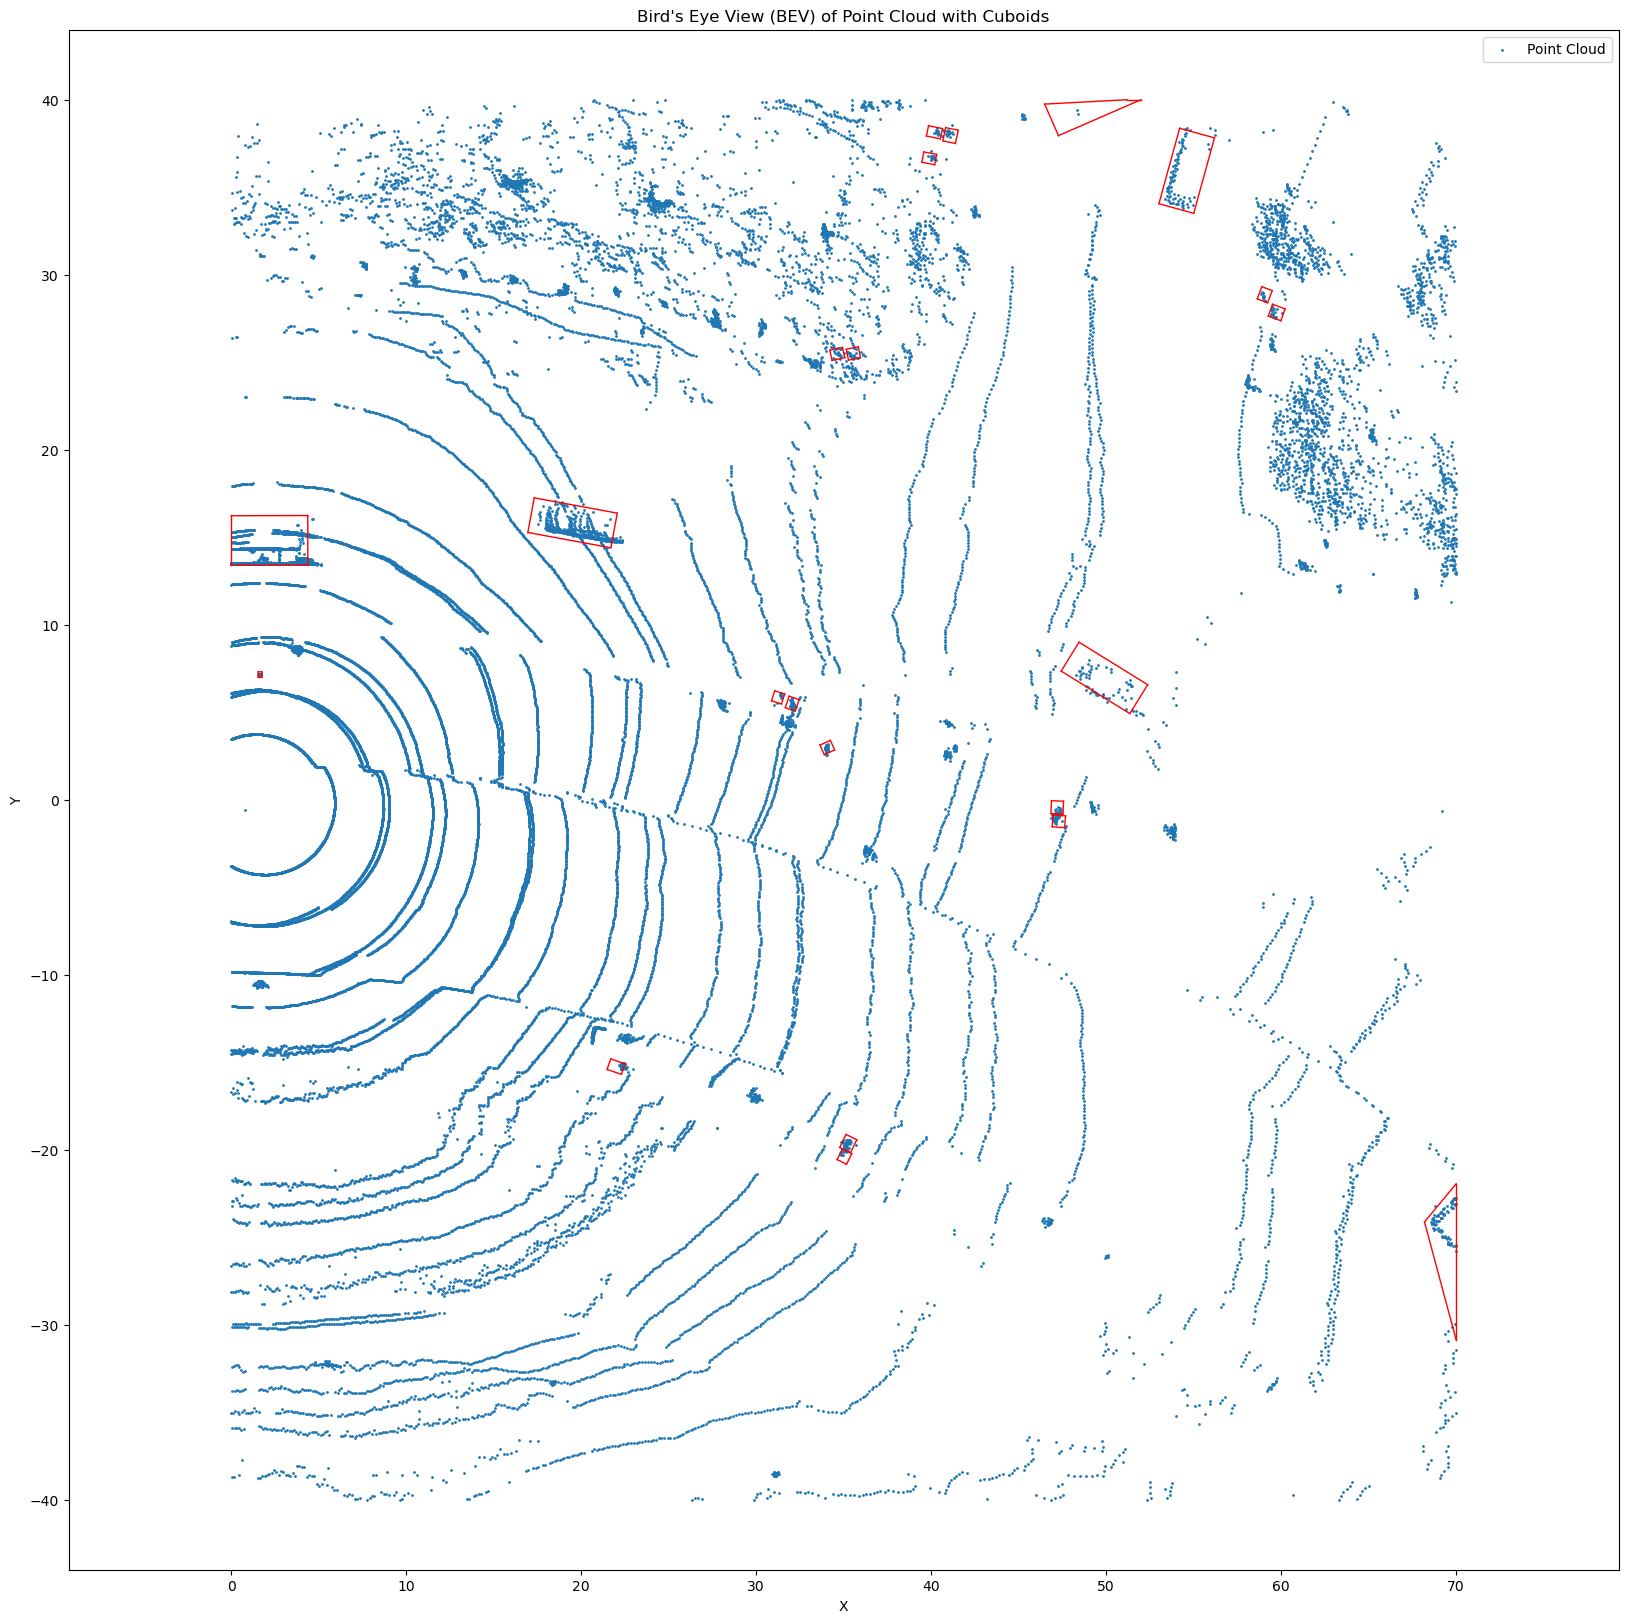

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_bev_with_cuboids_ROI_clamped(points: np.ndarray, cuboids: np.ndarray, fig_size=(10, 10), bottom_face_flag=True, x_min=-10, x_max=10, y_min=-10, y_max=10):
    """
    Visualize a 2D BEV (Bird's Eye View) of the point cloud with cuboid annotations.

    Args:
        points (numpy.ndarray): Nx3 array representing the point cloud.
        cuboids (numpy.ndarray): Array of shape (N, 8, 3), where N is the number of cuboids,
                                 8 represents the 8 corners, and 3 represents (X, Y, Z) coordinates.
    
            5------4
            |\\    |\\
            | \\   | \\
            6--\\--7  \\
            \\  \\  \\ \\
        l    \\  1-------0    h
         e    \\ ||   \\ ||   e
          n    \\||    \\||   i
           g    \\2------3    g
            t      width.     h
             h.               t
    """
    # Extract the X and Y coordinates from the point cloud
    x = points[:, 0]
    y = points[:, 1]

    # Plot the BEV of the point cloud
    plt.figure(figsize=fig_size)
    plt.scatter(x, y, s=1, label="Point Cloud")  # s=1 for small point size
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("Bird's Eye View (BEV) of Point Cloud with Cuboids")
    plt.axis('equal')

    # Process and visualize each cuboid
    for cuboid in cuboids:
        face_index = []
        if bottom_face_flag:
            face_index = [0, 1, 5, 4]
        else: 
            face_index = [3, 2, 6, 7]
        projected_corners = cuboid[face_index, :2]  # Take only the X-Y coordinates

        # Clamp the coordinates to the ROI range
        projected_corners[:, 0] = np.clip(projected_corners[:, 0], x_min, x_max)
        projected_corners[:, 1] = np.clip(projected_corners[:, 1], y_min, y_max)

        # Define connections for the cuboid's bottom face (BEV)
        connections = [
            [0, 1], [1, 2], [2, 3], [3, 0]  # Connections between corners of the bottom face
        ]

        # Draw lines for the cuboid in the BEV
        for start, end in connections:
            plt.plot(
                [projected_corners[start, 0], projected_corners[end, 0]],
                [projected_corners[start, 1], projected_corners[end, 1]],
                color='red', linewidth=1
            )
    
    plt.legend()
    plt.show()

# Define the ROI range
x_min, x_max = 0, 70
y_min, y_max = -40, 40

# Filter points based on the ROI
roi_mask = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
filtered_points = points[roi_mask]

# Filter cuboids based on the ROI
filtered_cuboids = []
for cuboid in corners:
    if np.any((cuboid[:, 0] >= x_min) & (cuboid[:, 0] <= x_max) & (cuboid[:, 1] >= y_min) & (cuboid[:, 1] <= y_max)):
        filtered_cuboids.append(cuboid)
filtered_cuboids = np.array(filtered_cuboids)

# Example Usage:
# Assuming `points` is an Nx3 numpy array representing the point cloud
# Assuming `corners` is an (N, 8, 3) numpy array of cuboid corner coordinates
visualize_bev_with_cuboids_ROI_clamped(filtered_points, filtered_cuboids, fig_size=(20, 20), bottom_face_flag=True, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)